In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


# Calculate the date 1 year ago from today
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
prcp_12_months = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date>last_year).order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df_12 = pd.DataFrame(prcp_12_months, columns=["Date", "Precipitation"])
df_12.set_index("Date")


# Sort the dataframe by date
df_12 = df_12.sort_values(by="Date", ascending=False)


# Use Pandas Plotting with Matplotlib to plot the data
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Precipitation For Past Year")

months = ["Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]

y = df_12["Precipitation"].tolist()
x = np.arange(0, len(df_12.index.tolist()), 1)

month_total = len(y)
month_step_xticks = int((month_total / 12)*1.03)
plt.ylim = max(y) + 1
tick_locations = [x+55 for x in range(1, month_total, month_step_xticks)]

plt.bar(x, y, width=25, color="blue", alpha=0.5)
plt.xticks(tick_locations, months)

plt.tight_layout()


# Rotate the xticks for the dates
plt.xticks(rotation=45)

plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_12.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print(locations)

9


In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

df_active = pd.DataFrame(data=most_active, columns=["Station", "Count"])

busiest = most_active[0][0]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == busiest).\
        filter(Measurement.date>last_year).order_by(Measurement.date).all()

temp_df = pd.DataFrame(temp)

min = temp_df["tobs"].min()
max = temp_df["tobs"].max()
avg = temp_df["tobs"].mean()

print(min, max, avg)

59.0 83.0 73.0968660968661


<IPython.core.display.Javascript object>


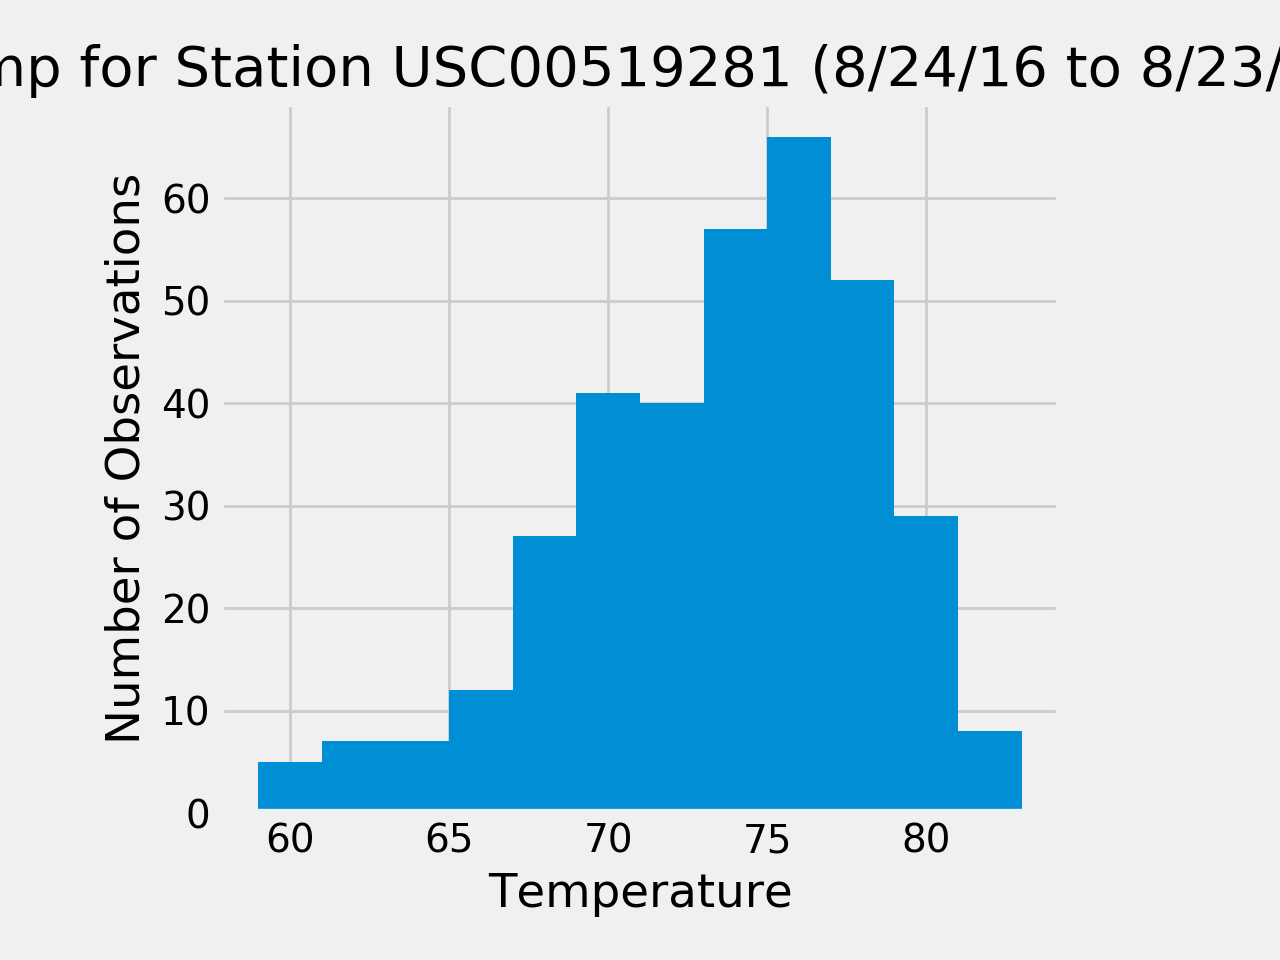

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temp_df["tobs"], 12)
plt.xlabel("Temperature")
plt.ylabel("Number of Observations")
plt.title("Temp for Station " + busiest + " (8/24/16 to 8/23/17)")
plt.tight_layout()
plt.show()

In [18]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-06-30', '2012-07-11'))

[(68.0, 74.70930232558139, 81.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_depart = dt.date(2017, 6, 30)
trip_return = dt.date(2017, 7, 11)

last_trip = dt.timedelta(days=365)
temp_trip = (calc_temps((trip_depart-last_trip), (trip_return-last_trip)))

tmin = temp_trip[0][0]
tavg = temp_trip[0][1]
tmax = temp_trip[0][2]

print(temp_trip)

[(71.0, 76.98630136986301, 82.0)]


<IPython.core.display.Javascript object>


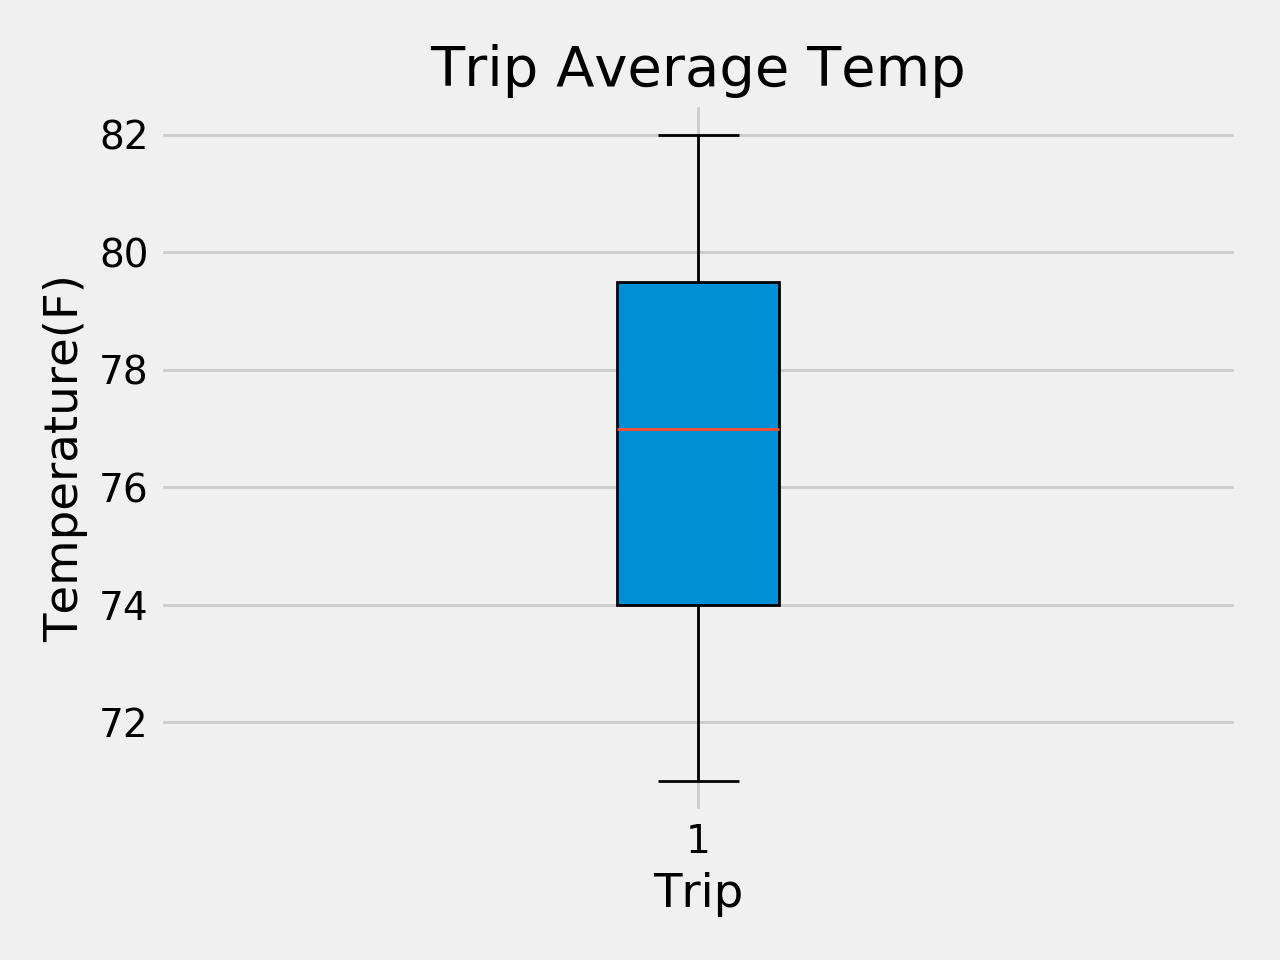

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x = range(len(temp_trip))
ax.boxplot(temp_trip, patch_artist=True)

ax.set_title('Trip Average Temp')
ax.set_ylabel("Temperature(F)")
ax.set_xlabel("Trip")

fig.tight_layout()
plt.show()

In [31]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_per_station = session.query(Measurement.station, 
                                     func.sum(Measurement.prcp),
                                     Station.name,
                                     Station.elevation,
                                     Station.latitude,
                                     Station.longitude).\
                        filter(Measurement.station == Station.station).\
                        filter(Measurement.date>last_year).\
                        group_by(Station.station).\
                        order_by(func.sum(Measurement.prcp).desc())

for row in rainfall_per_station:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()

Station:  USC00516128
    Rainfall:  1068.09  
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  588.64  
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00513117
    Rainfall:  382.62  
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  295.68  
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00514830
    Rainfall:  234.49  
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00519397
    Rainfall:  131.62  
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168

Station:  USC00511918
    Rainfall:  92.68  
    Elevation:  0.9      Latitude:  21.3152  Longitude:  -157.9992

Station:  USC00518838
    Rainfall:  70.87  
    Elevation:  306.6      Latitude:  21.4992  Longitude:  -158.0111

Station:  USC00517948
    Rainfall:  43.44  
    Elevation:  11.9    

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
